In [1]:
using LinearAlgebra
using GPFlux
using Plots; pyplot();
using Random; Random.seed!(4);
using Flux
using Zygote
using Optim
using DelimitedFiles
using Statistics
using Distributions
using Test

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("data/AirPassengers.csv", ',')
year = data[2:end,2]; passengers = data[2:end,3];
# Split the data into training and testing data
oxtrain = year[year.<1958]; oytrain = passengers[year.<1958];
oxtest = year[year.>=1958]; oytest = passengers[year.>=1958];

#data preprocessing
## standardize X and y
xtrain_mean = mean(oxtrain)
ytrain_mean = mean(oytrain)
xtrain_std = std(oxtrain)
ytrain_std = std(oytrain)
xtrain = @. (oxtrain-xtrain_mean)/xtrain_std
ytrain = @. (oytrain-ytrain_mean)/ytrain_std

xtest = @. (oxtest-xtrain_mean)/xtrain_std
ytest = @. (oytest-ytrain_mean)/ytrain_std

## input data
Xtrain = reshape(xtrain, 1, length(xtrain));
Xtest = reshape(xtest, 1, length(xtest));
Year = hcat(Xtrain, Xtest);
Passengers = vcat(ytrain, ytest);

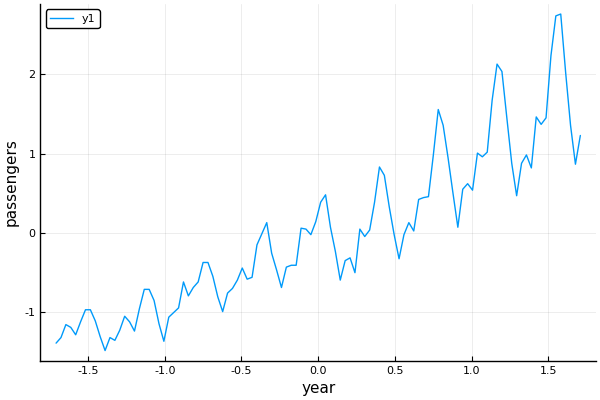

In [3]:
plot(xtrain, ytrain, xaxis=("year"), yaxis=("passengers"))

In [4]:
# kernel parameter initialization
function median_distance_local(x)
    n = length(x)
    dist = []
    for i in 1:n
        for j in i:n
            push!(dist, abs(x[j]-x[i]))
        end
    end
    median(dist)
end

l = median_distance_local(xtrain)

0.9897538280638507

In [ ]:
heu_iso_linear_kernel = IsoLinearKernel([0.0])
heu_iso_per_kernel = IsoPeriodKernel([log(l)], [log(l)], [0.0])
heu_iso_rbf_kernel = IsoGaussKernel([log(l)], [0.0])

heu_lin = Linear(3, 1) |> f64

heu_player = Primitive(heu_iso_linear_kernel, heu_iso_per_kernel, heu_iso_rbf_kernel)
heu_nkn = NeuralKernelNetwork(heu_player, heu_lin)

In [5]:
# construct kernels
iso_lin_kernel1 = IsoLinearKernel([0.0])
iso_per_kernel1 = IsoPeriodKernel([log(l)], [log(l)], [0.0])
iso_rbf_kernel1 = IsoGaussKernel([log(l/4.0)], [0.0])
iso_rq_kernel1 = IsoRQKernel([log(2.0*l)], [log(0.2)], [0.0])
iso_lin_kernel2 = IsoLinearKernel([0.0])
iso_rq_kernel2 = IsoRQKernel([log(l)], [log(0.1)], [0.0])
iso_rbf_kernel2 = IsoGaussKernel([log(l)], [0.0])
iso_per_kernel2 = IsoPeriodKernel([log(l/4.0)], [log(l/4.0)], [0.0])


# sum product network
linear1 = Linear(8, 8) |> f64
product1 = z -> GPFlux.Product(z, step=2)
linear2 = Linear(4, 4) |> f64
product2 = z -> GPFlux.Product(z, step=2)
linear3 = Linear(2, 1) |> f64

# mean function 
zero_mean = ConstantMean()

# NKN
player = Primitive(iso_lin_kernel1, iso_per_kernel1, iso_rbf_kernel1, iso_rq_kernel1,
                     iso_lin_kernel2, iso_rq_kernel2, iso_rbf_kernel2, iso_per_kernel2)
nkn = NeuralKernelNetwork(player, linear1, product1, linear2, product2, linear3)

NeuralKernelNetwork(Primitive(IsoLinearKernel(lσv=0.0), IsoPeriodKernel(lp=-0.010299025295520386, ll=-0.010299025295520386, lσ=0.0), IsoGaussKernel(ll=-1.396593386415411, lσ=0.0), IsoRQKernel(ll=0.6828481552644249, lα=-1.6094379124341003, lσ=0.0, IsoLinearKernel(lσv=0.0), IsoRQKernel(ll=-0.010299025295520386, lα=-2.3025850929940455, lσ=0.0, IsoGaussKernel(ll=-0.010299025295520386, lσ=0.0), IsoPeriodKernel(lp=-1.396593386415411, ll=-1.396593386415411, lσ=0.0)), Linear(8,8), #3, Linear(4,4), #5, Linear(2,1))

))

In [ ]:
# sample from prior
zero_mean = ConstantMean()
gp_prior = GaussProcess(zero_mean, nkn, [-Inf])
prior_dist = MvNormal(gp_prior, Xtrain)
samples = rand(prior_dist, 5)
plot(xtrain, samples)

In [6]:
# build gp model
zero_mean = ConstantMean()
lnoise = [0.5*log(0.1)]
gp = GaussProcess(zero_mean, nkn, lnoise)
ps = GPFlux.params(gp)
negloglik(gp, Xtrain, ytrain)

592.3691536132948

In [ ]:
function calc_g!(G, θ)
    dispatch!(gp, θ)
    ps = GPFlux.params(gp)
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)

    j = 1
    for p in ps
        lp = length(p)
        G[j:j+lp-1] .= vec(gs.grads[p])
        j += lp
    end
    G
end

function loss_fn(θ)
    dispatch!(gp, θ)
    negloglik(gp, Xtrain, ytrain)
end

θ = flatten_params(ps)
@show loss_fn(θ)
@show calc_g!(zeros(length(θ)), θ)
@test loss_fn(θ) ≈ negloglik(gp, Xtrain, ytrain)

In [ ]:
θ₀ = copy(θ)
res = optimize(loss_fn, calc_g!, θ₀, GradientDescent(), Optim.Options(g_tol=1e-3, store_trace=true,))

In [7]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:5000
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%100 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

┌ Info: step=1, loss=592.3691536132948
└ @ Main In[7]:11
┌ Info: step=100, loss=508.18951509961227
└ @ Main In[7]:11
┌ Info: step=200, loss=430.88984812270155
└ @ Main In[7]:11
┌ Info: step=300, loss=346.4025237097741
└ @ Main In[7]:11
┌ Info: step=400, loss=257.4541575498597
└ @ Main In[7]:11
┌ Info: step=500, loss=187.53502496676577
└ @ Main In[7]:11
┌ Info: step=600, loss=157.35766201535333
└ @ Main In[7]:11
┌ Info: step=700, loss=125.96821023399133
└ @ Main In[7]:11
┌ Info: step=800, loss=98.08832256501537
└ @ Main In[7]:11
┌ Info: step=900, loss=80.15323186086982
└ @ Main In[7]:11
┌ Info: step=1000, loss=65.77992360572763
└ @ Main In[7]:11
┌ Info: step=1100, loss=53.671733757814934
└ @ Main In[7]:11
┌ Info: step=1200, loss=43.03999742503622
└ @ Main In[7]:11
┌ Info: step=1300, loss=33.624154218575995
└ @ Main In[7]:11
┌ Info: step=1400, loss=25.540048583406445
└ @ Main In[7]:11
┌ Info: step=1500, loss=18.987853888840093
└ @ Main In[7]:11
┌ Info: step=1600, loss=14.099282393915388


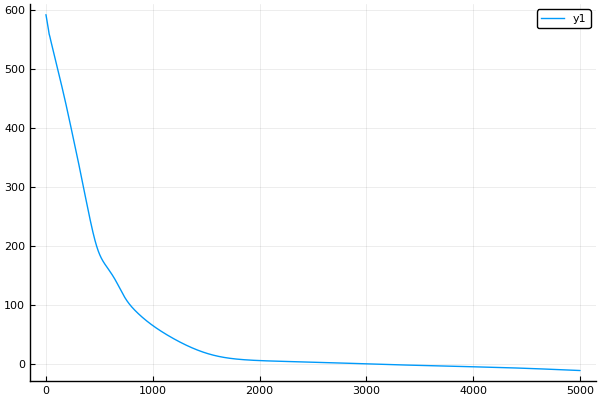

In [8]:
plot(loss)

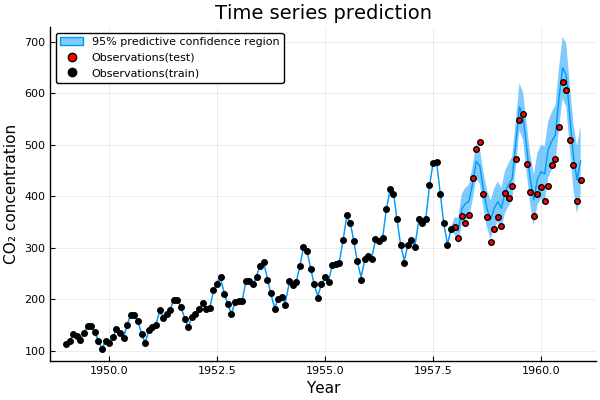

In [9]:
pred_y, pred_σ2 = predict(gp, Year, Xtrain, ytrain)
pred_σ = sqrt.(pred_σ2)
pred_oy = @. pred_y*ytrain_std+ytrain_mean
pred_oσ = @. pred_σ*ytrain_std

plot(year, pred_oy, ribbon=pred_oσ, title="Time series prediction",label="95% predictive confidence region")
scatter!(oxtest, oytest, label="Observations(test)", color=:red)
scatter!(oxtrain, oytrain, label="Observations(train)", color=:black)
plot!(xaxis=("Year"), yaxis=("Airline Passenger number"))